In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor 
import sqlite3
import math

/Users/ningsam/anaconda3/envs/YichenWang/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/3w/bkk9z93s1294lzphg00_yxnw0000gn/T/ipykernel_65443/497082063.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Read in the data from the database
# conn = sqlite3.connect('/content/drive/My Drive/tables.db')
conn = sqlite3.connect('/Users/ningsam/Desktop/Winter_2024/24W-PIC16B-Group4/data/tables.db')
# show database content
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())
# Extract two tables from it and store them in two pd df
ds = pd.read_sql_query("SELECT * from df_2023_h1_feature", conn)
target = pd.read_sql_query("SELECT * from df_2023_h1_target", conn)

[('df_2023_h1_feature',), ('df_2023_h1_target',)]


In [3]:
ds_new = ds.copy()
ds

,[QUOTE_UNIXTIME],[EXPIRE_UNIX],[STRIKE],[UNDERLYING_LAST],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],[C_IV],...,[C_ASK],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[P_BID],[P_ASK]
0,-1.69160,-1.531564,-1.054517,-2.406592,1.054125,-0.052714,0.000146,-0.391189,-0.307878,11.711458,...,0.676304,1.120791,-0.013192,0.001135,0.086874,0.592295,3.380989,-0.100406,-0.563368,-0.566211
1,-1.69160,-1.531564,-0.936052,-2.406592,1.041020,0.036229,0.000190,-0.390353,-0.308470,10.342762,...,0.479078,1.120350,-0.013031,0.001152,0.086843,0.592878,2.599981,-0.100406,-0.563368,-0.566211
2,-1.69160,-1.531564,-0.888665,-2.406592,1.035470,0.083539,0.000199,-0.393217,-0.308536,9.795964,...,0.400187,1.119196,-0.013111,0.001152,0.086442,0.592606,2.292638,-0.100406,-0.563368,-0.566211
3,-1.69160,-1.531564,-0.876819,-2.406592,1.048893,0.103725,0.000140,0.031159,-0.308217,9.553426,...,0.389734,1.120644,-0.013015,0.001157,0.086741,0.591011,2.214716,-0.100406,-0.563368,-0.566211
4,-1.69160,-1.531564,-0.864972,-2.406592,1.030873,0.108141,0.000225,-0.438792,-0.308574,9.529689,...,0.371195,1.119712,-0.013079,0.001120,0.086482,0.591167,2.139460,-0.100406,-0.563368,-0.566211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331604,1.78216,1.881977,0.367073,1.410238,-0.175447,0.125803,0.058474,0.064804,0.473889,-0.825637,...,-0.386156,-0.261286,0.003340,0.057390,0.064104,-2.657456,-0.483741,-0.100406,-0.191656,-0.130110
331605,1.78216,1.881977,0.426306,1.410238,-0.288188,0.141573,0.057498,0.121952,0.401497,-0.825637,...,-0.472936,-0.405104,0.004291,0.054827,0.067442,-2.681954,-0.504299,-0.100406,-0.142171,-0.085819
331606,1.78216,1.881977,0.485538,1.410238,-0.406236,0.147881,0.055627,0.179100,0.323910,-0.825637,...,-0.521651,-0.565709,0.005225,0.050409,0.071071,-2.573385,-0.528800,-0.100406,-0.090211,-0.033009
331607,1.78216,1.881977,0.544771,1.410238,-0.524528,0.142835,0.052804,0.249133,0.243663,-0.825637,...,-0.564252,-0.714509,0.005499,0.044680,0.074684,-2.371958,-0.536906,-0.100406,-0.024928,0.033049


In [4]:
# UMMM, we first standardize two cols 
from sklearn.preprocessing import StandardScaler
import warnings
with warnings.catch_warnings():
# ignore all caught warnings
    warnings.filterwarnings("ignore")
    scaler = StandardScaler()
    tbd = ['[QUOTE_UNIXTIME]', '[EXPIRE_UNIX]']
    ds_new[tbd] = scaler.fit_transform(ds[tbd])

In [5]:
ds

,[QUOTE_UNIXTIME],[EXPIRE_UNIX],[STRIKE],[UNDERLYING_LAST],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],[C_IV],...,[C_ASK],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[P_BID],[P_ASK]
0,-1.69160,-1.531564,-1.054517,-2.406592,1.054125,-0.052714,0.000146,-0.391189,-0.307878,11.711458,...,0.676304,1.120791,-0.013192,0.001135,0.086874,0.592295,3.380989,-0.100406,-0.563368,-0.566211
1,-1.69160,-1.531564,-0.936052,-2.406592,1.041020,0.036229,0.000190,-0.390353,-0.308470,10.342762,...,0.479078,1.120350,-0.013031,0.001152,0.086843,0.592878,2.599981,-0.100406,-0.563368,-0.566211
2,-1.69160,-1.531564,-0.888665,-2.406592,1.035470,0.083539,0.000199,-0.393217,-0.308536,9.795964,...,0.400187,1.119196,-0.013111,0.001152,0.086442,0.592606,2.292638,-0.100406,-0.563368,-0.566211
3,-1.69160,-1.531564,-0.876819,-2.406592,1.048893,0.103725,0.000140,0.031159,-0.308217,9.553426,...,0.389734,1.120644,-0.013015,0.001157,0.086741,0.591011,2.214716,-0.100406,-0.563368,-0.566211
4,-1.69160,-1.531564,-0.864972,-2.406592,1.030873,0.108141,0.000225,-0.438792,-0.308574,9.529689,...,0.371195,1.119712,-0.013079,0.001120,0.086482,0.591167,2.139460,-0.100406,-0.563368,-0.566211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331604,1.78216,1.881977,0.367073,1.410238,-0.175447,0.125803,0.058474,0.064804,0.473889,-0.825637,...,-0.386156,-0.261286,0.003340,0.057390,0.064104,-2.657456,-0.483741,-0.100406,-0.191656,-0.130110
331605,1.78216,1.881977,0.426306,1.410238,-0.288188,0.141573,0.057498,0.121952,0.401497,-0.825637,...,-0.472936,-0.405104,0.004291,0.054827,0.067442,-2.681954,-0.504299,-0.100406,-0.142171,-0.085819
331606,1.78216,1.881977,0.485538,1.410238,-0.406236,0.147881,0.055627,0.179100,0.323910,-0.825637,...,-0.521651,-0.565709,0.005225,0.050409,0.071071,-2.573385,-0.528800,-0.100406,-0.090211,-0.033009
331607,1.78216,1.881977,0.544771,1.410238,-0.524528,0.142835,0.052804,0.249133,0.243663,-0.825637,...,-0.564252,-0.714509,0.005499,0.044680,0.074684,-2.371958,-0.536906,-0.100406,-0.024928,0.033049


In [6]:
target

,discounted_price
0,-63.916774
1,-54.101350
2,-50.175181
3,-49.193639
4,-48.212096
...,...
331604,-18.619560
331605,-13.711848
331606,-8.804136
331607,-3.896425


In [7]:
# Merge target and ds directly, as they match and have the same length
ds_new = pd.concat([ds_new, target], axis=1)

In [8]:
ds_new.columns

Index(['[QUOTE_UNIXTIME]', '[EXPIRE_UNIX]', '[STRIKE]', '[UNDERLYING_LAST]',
       '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]', '[C_IV]',
       '[C_VOLUME]', '[C_BID]', '[C_ASK]', '[P_DELTA]', '[P_GAMMA]',
       '[P_VEGA]', '[P_THETA]', '[P_RHO]', '[P_IV]', '[P_VOLUME]', '[P_BID]',
       '[P_ASK]', 'discounted_price'],
      dtype='object')

In [9]:
# Add new cols for the target, namely -rt and price diff
ds_new['-rt'] = -0.04*(ds['[EXPIRE_UNIX]'] - ds['[QUOTE_UNIXTIME]'])/(3600*365*24)
ds_new['price_diff'] = ds_new['[STRIKE]'] - ds_new['discounted_price']
ds_new['-rt'] = pd.to_numeric(ds_new['-rt'])
ds_new['exp(-rt)'] = ds_new['-rt'].apply(lambda x: math.exp(x))
ds_new = ds_new.loc[:, ~ds_new.columns.str.contains('^Unnamed')]  
ds = ds.loc[:, ~ds.columns.str.contains('^Unnamed')]

In [10]:
features = ds_new[['[QUOTE_UNIXTIME]', '[EXPIRE_UNIX]', '[STRIKE]', '[UNDERLYING_LAST]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
       '[C_THETA]', '[C_RHO]', '[C_IV]', '[C_VOLUME]','[C_BID]', '[C_ASK]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]',
       '[P_RHO]', '[P_IV]', '[P_VOLUME]', '[P_BID]', '[P_ASK]']].values
target_1= ds_new['price_diff']*ds_new['exp(-rt)']
seq_length = 10 # Number of days to look back


In [11]:
# ds_new = ds_new[:30000]
# ds = ds[:30000]
# target_1 = target_1[:30000]


In [12]:
# Sequence creation
def seq(data, seq_length):
    xseq = []
    yseq = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = target_1[i+seq_length]
        xseq.append(x)
        yseq.append(y)
    return np.array(xseq), np.array(yseq)
X,y = seq(features, seq_length)

In [13]:
X.shape, y.shape

((331598, 10, 22), (331598,))

In [14]:
target_1.shape

(331609,)

In [15]:
target_1_seq = np.array(target_1)

In [16]:
# from sklearn.model_selection import train_test_split
# # First, split the data into training + validation and testing sets
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# # Then, split the training + validation into separate training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 is roughly 15% of the original dataset
# Training: 70%, Validation: 15%, Test: 15%
X_train = X[:210000]
y_train = y[:210000]

X_val = X[210000:255000]
y_val = y[210000:255000]

X_test = X[255000:]
y_test = y[255000:]

In [17]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
X_train = X_train.astype(float)  # Convert to float if it's a numpy array
X_train = torch.tensor(X_train, dtype=torch.float)  # Then convert to a PyTorch tensor
y_train = torch.tensor(y_train, dtype=torch.float)
X_val = torch.tensor(X_val, dtype=torch.float)
y_val = torch.tensor(y_val, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

torch.Size([210000, 10, 22]) torch.Size([210000, 1]) torch.Size([45000, 10, 22]) torch.Size([45000, 1]) torch.Size([76598, 10, 22]) torch.Size([76598, 1])


In [18]:
# y_train = y_train.squeeze(1)  # Removes the unnecessary middle dimension
# y_val = y_val.squeeze(1)
# y_test = y_test.squeeze(1)

In [19]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: torch.Size([210000, 10, 22]) torch.Size([210000, 1])
Validation shapes: torch.Size([45000, 10, 22]) torch.Size([45000, 1])
Test shapes: torch.Size([76598, 10, 22]) torch.Size([76598, 1])


In [20]:
class RNN_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1,dropout=0.5):
        super(RNN_2, self).__init__()
        # hidden layer size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc1 = nn.Linear(output_size, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        test_h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # print(f"test_h0 has shape,{test_h0.shape}")  # Should work without error and print the shape)
        # initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, _ = self.lstm(x, (h0.detach(), c0.detach()))
        output = self.fc(output[:, -1, :])
        output = self.relu(output)
        output = self.fc1(output)
        return output
    
# Model instantiation
model = RNN_2(input_size=X_train.shape[2], hidden_size=50, num_layers=3)


In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# For early stopping
patience = 20
optimal_val_loss = np.inf
current_patience = 0
# Training phase
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    assert outputs.shape == y_train.shape, f"Shape mismatch: outputs {outputs.shape}, target {y_train.shape}"
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        # Early stopping
        if val_loss < optimal_val_loss:
            optimal_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            current_patience = 0
        else:
            current_patience += 1
            if current_patience == patience:
                print(f'Early stopping at epoch {epoch+1}')
                # load best model
                model.load_state_dict(torch.load('best_model.pt'))
                break
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch [10/100], Loss: 2079.597412109375, Val Loss: 1332.1807861328125
Epoch [20/100], Loss: 1227.7471923828125, Val Loss: 974.398193359375
Epoch [30/100], Loss: 1084.1314697265625, Val Loss: 896.3646240234375
Epoch [40/100], Loss: 1020.8162231445312, Val Loss: 826.0626831054688
Epoch [50/100], Loss: 983.646728515625, Val Loss: 793.7745971679688
Epoch [60/100], Loss: 962.9719848632812, Val Loss: 803.22705078125
Epoch [70/100], Loss: 942.3965454101562, Val Loss: 795.1156616210938
Epoch [80/100], Loss: 931.7525634765625, Val Loss: 731.8887329101562
Epoch [90/100], Loss: 921.1461181640625, Val Loss: 737.30126953125
Epoch [100/100], Loss: 942.90771484375, Val Loss: 745.2267456054688


Test Loss: 330.4825134277344
MSE Loss: 330.4825134277344
R2 Score: 0.8154839643611254


Text(0.5, 1.0, 'Test Set Predictions')

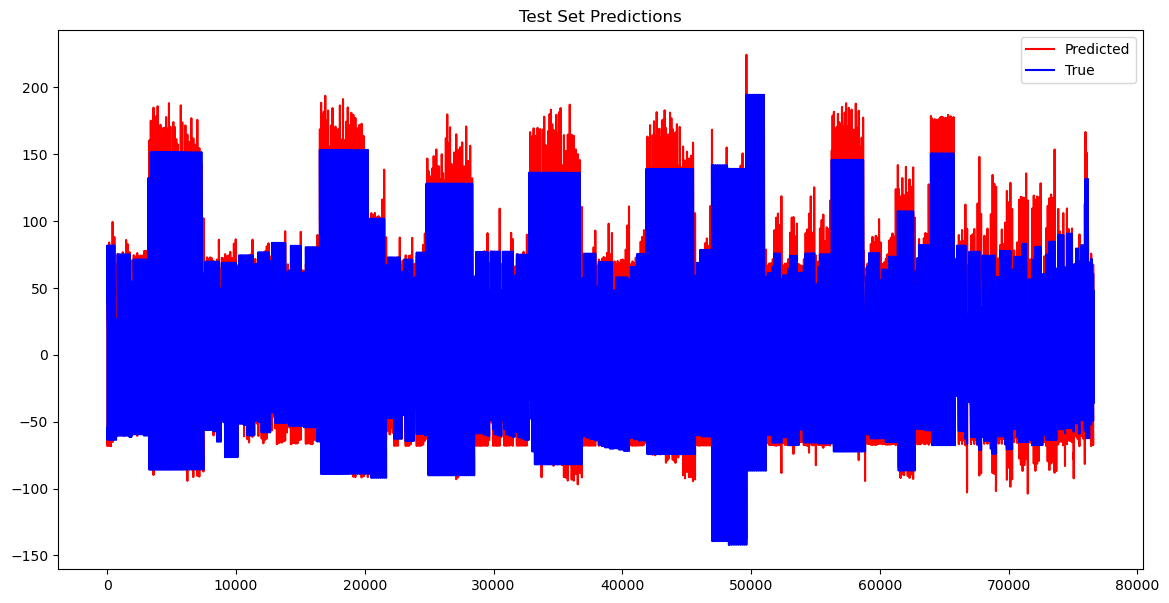

In [30]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item()}')
criterion = torch.nn.MSELoss()
mse_loss = criterion(predictions, y_test)
print(f"MSE Loss: {mse_loss.item()}")
# R2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)
print(f"R2 Score: {r2}")

# Visualize the results with different colors
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
# plt.plot(y_test, label = "True", color = 'blue')
plt.plot(predictions, label='Predicted',color = 'red')
plt.plot(y_test, label = "True", color = 'blue')
plt.legend()
plt.title('Test Set Predictions')